## Import all Required Modules

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import wordcloud

## Data Exploration and Cleaning

### Downloading the dataset

In [52]:
!gdown 1QpJeDYbW3r-Kc6pJVU7InQbumrx07vxi #train (1).csv
!gdown 10eBqcJ00SbwPCBUImJ5F7U5P1bPRZptJ #test (1).csv
!gdown 1LX5z3FiJNycj5yXZ0q5AUwojYK5vaDL4 #sample_submission.csv

Downloading...
From: https://drive.google.com/uc?id=1QpJeDYbW3r-Kc6pJVU7InQbumrx07vxi
To: /content/train (1).csv
100% 988k/988k [00:00<00:00, 119MB/s]
Downloading...
From: https://drive.google.com/uc?id=10eBqcJ00SbwPCBUImJ5F7U5P1bPRZptJ
To: /content/test (1).csv
100% 421k/421k [00:00<00:00, 82.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LX5z3FiJNycj5yXZ0q5AUwojYK5vaDL4
To: /content/sample_submission.csv
100% 22.7k/22.7k [00:00<00:00, 50.7MB/s]


### Loading the train CSV file to a Pandas Dataframe

In [14]:
train = pd.read_csv('train (1).csv')

### Inspecting Dataframes

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [16]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


### Target Distribution

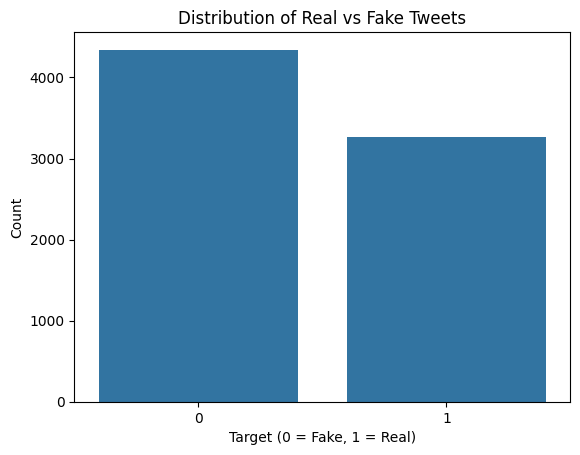

In [17]:
sns.countplot(x='target', data=train)
plt.title('Distribution of Real vs Fake Tweets')
plt.xlabel('Target (0 = Fake, 1 = Real)')
plt.ylabel('Count')
plt.show()

### Top Keywords

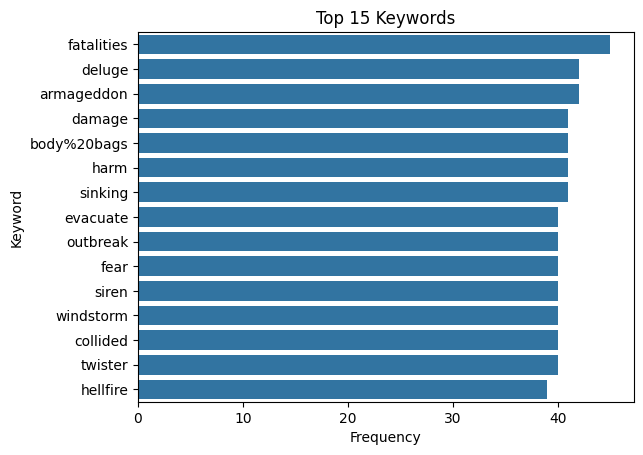

In [18]:
top_keywords = train['keyword'].value_counts().nlargest(15)
sns.barplot(y=top_keywords.index, x=top_keywords.values)
plt.title('Top 15 Keywords')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()

### Wordclouds

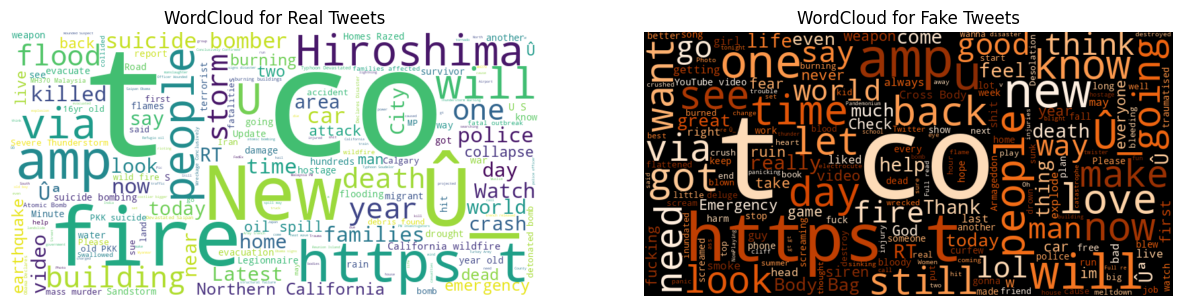

In [19]:
real_words = ' '.join(train[train['target'] == 1]['text'])
fake_words = ' '.join(train[train['target'] == 0]['text'])

wordcloud_real = wordcloud.WordCloud(width=800, height=400, background_color='white').generate(real_words)
wordcloud_fake = wordcloud.WordCloud(width=800, height=400, background_color='black', colormap='Oranges').generate(fake_words)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Real Tweets')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Fake Tweets')

plt.show()


### Cleaning the datasets

In [24]:
train['keyword'] = train['keyword'].fillna('none')
train['location'] = train['location'].fillna('unknown')

test['keyword'] = test['keyword'].fillna('none')
test['location'] = test['location'].fillna('unknown')
train = train.drop_duplicates()

## Text Preprocessing

In [28]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)         # remove URLs
    text = re.sub(r'@\w+', '', text)                   # remove mentions
    text = re.sub(r'#\w+', '', text)                   # remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)            # remove non-alphabets
    text = text.lower()                                # to lowercase
    return text

train['clean_text'] = train['text'].apply(clean_text)

nltk.download('stopwords')
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    words = text.split()
    filtered = [stemmer.stem(w) for w in words if w not in stop_words]
    return ' '.join(filtered)

train['clean_text'] = train['clean_text'].apply(preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Feature Extraction

In [38]:
# Bag of Words
count_vec = CountVectorizer(max_features=5000)
X_count = count_vec.fit_transform(train['clean_text'])

# TF-IDF
tfidf_vec = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vec.fit_transform(train['clean_text'])

# Target variable
y = train['target']

## Building and Training the Model

In [41]:
X_train_cv, X_test_cv, y_train, y_test = train_test_split(X_count, y, test_size=0.2, random_state=64)
X_train_tf, X_test_tf, _, _ = train_test_split(X_tfidf, y, test_size=0.2, random_state=64)

def plot_conf_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def train_and_evaluate(model, X_train, X_test, y_train, y_test, name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    plot_conf_matrix(y_test, y_pred, title=f"{name} - Confusion Matrix")
    print("Classification Report:\n", classification_report(y_test, y_pred))

### Using BOW features for training


=== Logistic Regression (BoW) ===
Accuracy: 0.788575180564675


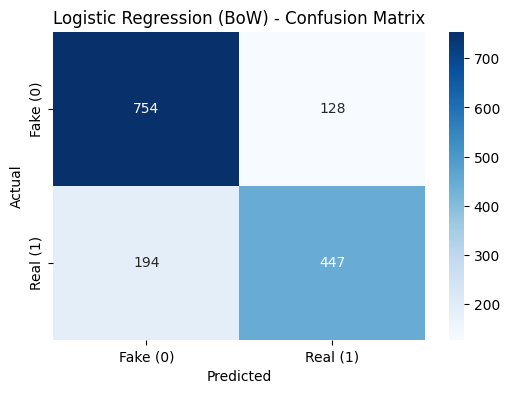

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82       882
           1       0.78      0.70      0.74       641

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523


=== SVM (BoW) ===
Accuracy: 0.768220617202889


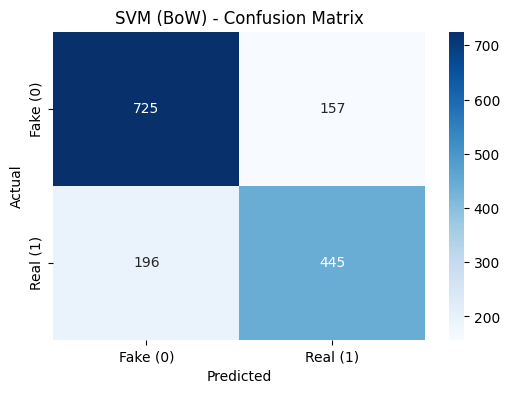

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.80       882
           1       0.74      0.69      0.72       641

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523


=== Naive Bayes (BoW) ===
Accuracy: 0.7892317793827971


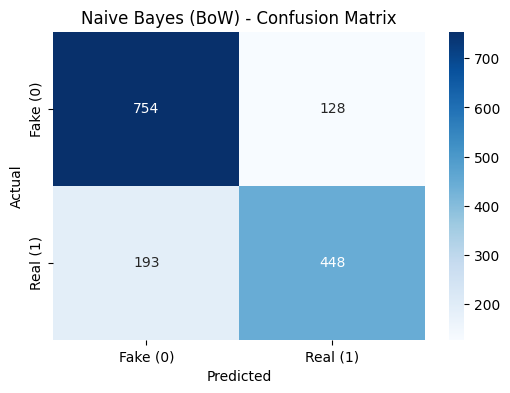

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82       882
           1       0.78      0.70      0.74       641

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



In [42]:
train_and_evaluate(LogisticRegression(), X_train_cv, X_test_cv, y_train, y_test, "Logistic Regression (BoW)")
train_and_evaluate(SVC(kernel='linear'), X_train_cv, X_test_cv, y_train, y_test, "SVM (BoW)")
train_and_evaluate(MultinomialNB(), X_train_cv, X_test_cv, y_train, y_test, "Naive Bayes (BoW)")

### Using TF-IDF feature for training


=== Logistic Regression (TF-IDF) ===
Accuracy: 0.7866053841103086


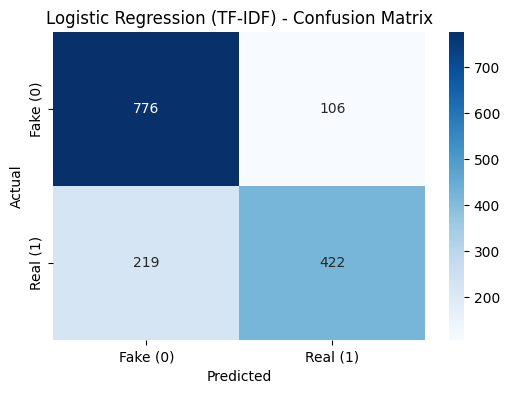

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.83       882
           1       0.80      0.66      0.72       641

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.77      1523
weighted avg       0.79      0.79      0.78      1523


=== SVM (TF-IDF) ===
Accuracy: 0.783322390019698


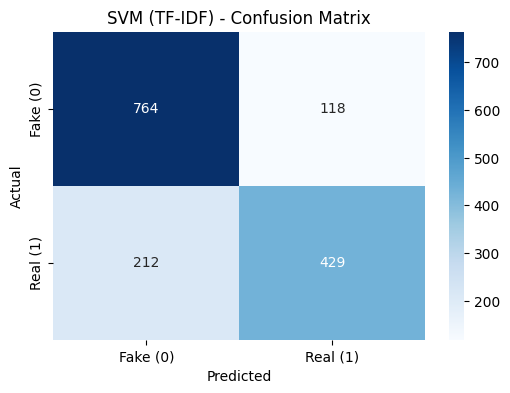

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82       882
           1       0.78      0.67      0.72       641

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523


=== Naive Bayes (TF-IDF) ===
Accuracy: 0.799080761654629


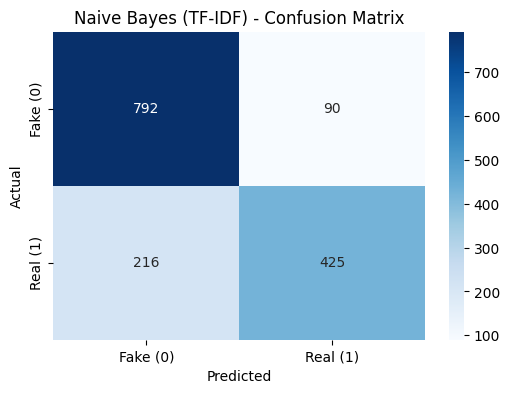

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       882
           1       0.83      0.66      0.74       641

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



In [43]:
train_and_evaluate(LogisticRegression(), X_train_tf, X_test_tf, y_train, y_test, "Logistic Regression (TF-IDF)")
train_and_evaluate(SVC(kernel='linear'), X_train_tf, X_test_tf, y_train, y_test, "SVM (TF-IDF)")
train_and_evaluate(MultinomialNB(), X_train_tf, X_test_tf, y_train, y_test, "Naive Bayes (TF-IDF)")

### Analysis
- All models are finding it difficult to predict some real news more than the fake news
- All models succeed in predicting fake news (above 87 percent accurate)
- I am using MultinomialNB model with TF-IDF features since it has highest accuracy of 80 percentage

In [45]:
final_model = MultinomialNB()
final_model.fit(X_tfidf, train['target'])

MultinomialNB()

#### Transforming Test dataset same way as train data set

In [48]:
test = pd.read_csv('test (1).csv')

# Fill missing values
test['keyword'] = test['keyword'].fillna('none')
test['location'] = test['location'].fillna('unknown')

# Preprocessing
test['clean_text'] = test['text'].apply(clean_text)
test['clean_text'] = test['clean_text'].apply(preprocess)

# Transform using same TF-IDF vectorizer
X_test_final = tfidf_vec.transform(test['clean_text'])

#### Final Predictions

In [50]:
test_predictions = final_model.predict(X_test_final)
pd.Series(test_predictions).value_counts().sort_index().rename(index={0: "Fake (0)", 1: "Real (1)"})

,count
Fake (0),2162
Real (1),1101


## Creating the final submission file

In [53]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = test_predictions
submission.to_csv('submission.csv', index=False)